# Training sigmoid funstion for gene activations

In [1]:
% matplotlib inline
import os, glob
import numpy as np
import matplotlib.pylab as plt

In [2]:
PATH_IMAGES = '/datagrid/Medical/microscopy/drosophila/TEMPORARY/annot-user-labels-train/'
PATH_ACTIVE_IMGS = os.path.join(PATH_IMAGES, 'positive/*.png')
PATH_PASIVE_IMGS = os.path.join(PATH_IMAGES, 'negative/*.png')
PATH_SEGMS = PATH_IMAGES_SEGS = '/datagrid/Medical/microscopy/drosophila/RESULTS/PIPELINE_ovary_all_images/1_init_tissue_segmentation'
lp_active = glob.glob(PATH_ACTIVE_IMGS)
lp_pasive = glob.glob(PATH_PASIVE_IMGS)
print('numbers of active: %i and pasive: %i example' % (len(lp_active), len(lp_pasive)))

numbers of active: 185 and pasive: 47 example


## Compute histograms

In [3]:
def extract_images(lp_images, path_segms=None):
    imgs_px = []
    for p_img in lp_images:
        im = plt.imread(p_img)[:, :, 1]
        if path_segms is None:
            seg = np.ones(im.shape)
        else:
            p_seg = os.path.join(path_segms, os.path.splitext(os.path.basename(p_img))[0] + '.png')
            if not os.path.isfile(p_seg):
                continue
            seg = plt.imread(p_seg) > 0
        imgs_px.append(im.ravel()[seg.ravel() > 0])
    return imgs_px

In [4]:
def compute_histogram(imgs_px):
    hists = []
    for ip in imgs_px:
        hg, b = np.histogram(ip, bins=75)
        hg = (hg / float(np.sum(hg)))
        hists.append(hg)
    bins = (b[1:] + b[:-1]) / 2.
    return hists, bins

In [5]:
def show_histogram(name, hists, bins):
    if len(hists) == 0:
        return 
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1), plt.plot(bins / np.max(bins), np.array(hists).T)
    plt.grid(), plt.xlabel('gene intensity'), plt.suptitle(name)
    plt.subplot(1, 2, 2), plt.semilogy(bins / np.max(bins), np.array(hists).T)
    plt.grid(), plt.xlabel('gene intensity'), plt.suptitle(name)
    # plt.xticks(range(75)[::5], [str(round(b * 255)) for b in bins[::5]])

histograms over all images with filtered interior

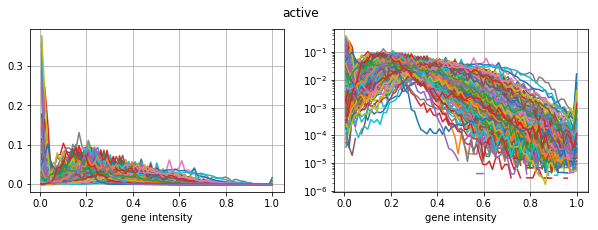

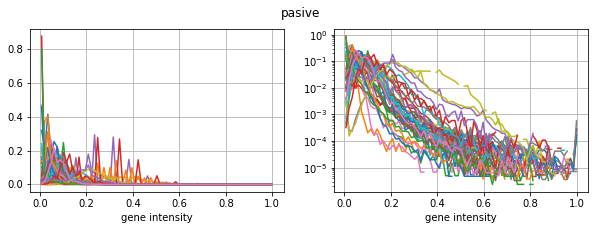

In [6]:
for name, lp_images in [('active', lp_active), ('pasive', lp_pasive)]:
    imgs_px = extract_images(lp_images, path_segms=PATH_SEGMS)
    hists, bins = compute_histogram(imgs_px)
    show_histogram(name, hists, bins)

grouped histogram

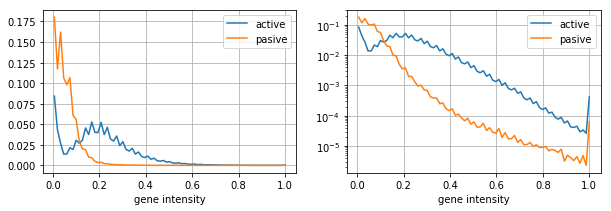

In [7]:
d_hist = {}
for name, lp_images in [('active', lp_active), ('pasive', lp_pasive)]:
    imgs_px = extract_images(lp_images, path_segms=PATH_SEGMS)
    imgs_px = [np.hstack(imgs_px)]
    hists, bins = compute_histogram(imgs_px)
    d_hist[name] = hists[0]

bins_norm = bins / np.max(bins)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
for k in d_hist:
    plt.plot(bins_norm, d_hist[k], label=k)
_= plt.grid(), plt.xlabel('gene intensity'), plt.legend()
plt.subplot(1, 2, 2)
for k in d_hist:
    plt.semilogy(bins_norm, d_hist[k], label=k)
_= plt.grid(), plt.xlabel('gene intensity'), plt.legend()

## Fuzzy activations

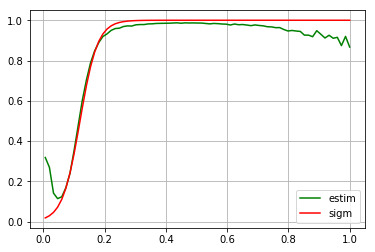

In [8]:
dec = d_hist['active'] / (d_hist['active'] + d_hist['pasive'])
sigm = lambda x, a, b: 1. / (1 + np.exp(b * (- x + a)))

plt.plot(bins_norm, dec, 'g', label='estim')
plt.plot(bins_norm, sigm(bins_norm, 0.12, 35.), 'r', label='sigm')
_= plt.grid(), plt.legend()

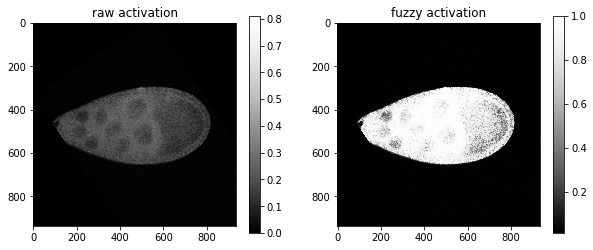

In [16]:
img = plt.imread(lp_active[-1])[:, :, 1]
plt.figure(figsize=(10, 4))
_= plt.subplot(1, 2, 1), plt.title('raw activation'), plt.imshow(img, cmap=plt.cm.Greys_r), plt.colorbar()
_= plt.subplot(1, 2, 2), plt.title('fuzzy activation'), plt.imshow(sigm(img, 0.12, 35.), cmap=plt.cm.Greys_r), plt.colorbar()